In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import itertools
import math
from scipy.sparse import diags
import scipy
from matplotlib.pyplot import figure

# Section 1: Geometric Brownian Motion Model

## Download Data

In [2]:
df = web.DataReader('^HSI', 'yahoo', start='2021-01-01', end='2022-02-28')

## Plot HSI Closing Level

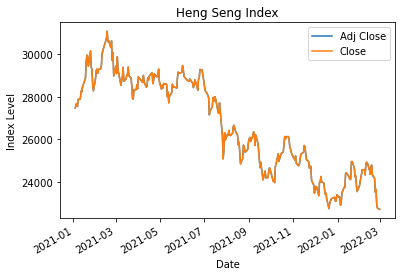

In [3]:
df[['Adj Close', 'Close']].plot()
plt.title('Heng Seng Index')
plt.ylabel('Index Level');

## Estimate Parameters: mu & Sigma

In [4]:
# daily log-return
daily_log_ret = np.log(df['Close']).diff()

# daily estimated sigma
daily_log_sigma = daily_log_ret.std()

# daily estimated mu
daily_log_mu = daily_log_ret.mean() + 0.5 * daily_log_sigma * daily_log_sigma

# annual mu and annual sigma
annual_sigma = daily_log_sigma * np.sqrt(250)
annual_mu = daily_log_ret.mean() * 250 + 1/2 * annual_sigma * annual_sigma

print(f'Daily - mu: {daily_log_mu}, volatility: {daily_log_sigma}')
print(f'Annual - mu: {annual_mu}, volatility: {annual_sigma}')

Daily - mu: -0.0005855832612943568, volatility: 0.012987766259135064
Annual - mu: -0.1463958153235892, volatility: 0.20535461548375727


## Simulate Stock Path Using Estimated mu & Sigma

In [5]:
def simulate_stock_paths(n_paths, n_days, S0, mu, sigma, dt=1/250):
    dz = np.random.normal(0,1,(n_paths, n_days))
    
    def get_random(path_id, dz):
        path_zs = dz[path_id]
        for i in range(len(path_zs)):
            yield path_zs[i]
            
    # store all paths
    paths = list()
    # iterate each path
    for path_id in range(n_paths):
        # first price is the latest close on 2022-02-28
        cur_path = [S0]
        # get generator
        zs = get_random(path_id, dz)
        for z in zs:
            # dS = S(t) * (u dt + sigma * dZ * sqrt(dt)), dt=1
            # S(t+1) = S(t) + dS(t)
            cur_path.append(cur_path[-1] * np.exp((annual_mu-1/2*annual_sigma*annual_sigma)/250+annual_sigma*np.sqrt(1/250)*z))
            
        paths.append(cur_path)
    return np.array(paths)

# initial value is the closing level on 2022-02-28
S0 = df['Close'].loc['2022-02-28']

# generated stock paths
stock_paths = simulate_stock_paths(1000,250, S0, annual_mu, annual_sigma)

### Plot Simulated Trajectories

Text(0.5, 0, 'Trading days onward from 2022-02-08')

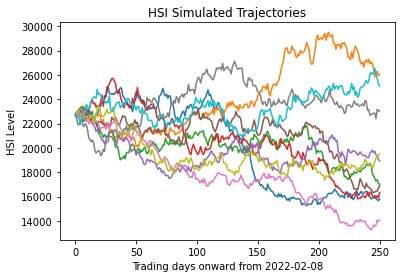

In [6]:
# plot first 10 paths
trading_days = range(251)
for i in range(10):
    plt.plot(trading_days, stock_paths[i, :])
plt.title('HSI Simulated Trajectories')
plt.ylabel('HSI Level')
plt.xlabel('Trading days onward from 2022-02-08')

### Calculate Statistics of the trajectories

In [170]:
max_S = np.max(stock_paths,1)
min_S = np.min(stock_paths,1)
avg_S = np.mean(stock_paths,1)
std_ret_S = np.std(stock_paths[:, 1:]/stock_paths[:, :-1]-1,1)
std_log_ret_S = np.std(np.diff(np.log(stock_paths)),1)
paths_log_mu = np.mean(np.diff(np.log(stock_paths)),1)
paths_log_vol = np.std(np.diff(np.log(stock_paths)),1)

## Plot distribution of statistics

Text(0.5, 0, 'HSI level')

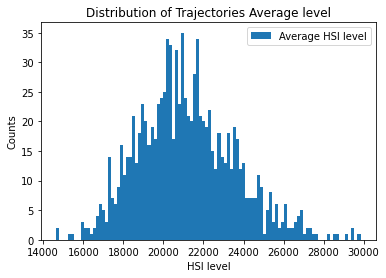

In [171]:
plt.hist(avg_S, bins=100);
plt.legend(['Average HSI level'])
plt.title('Distribution of Trajectories Average level');
plt.ylabel('Counts')
plt.xlabel('HSI level')

Text(0.5, 0, 'HSI level')

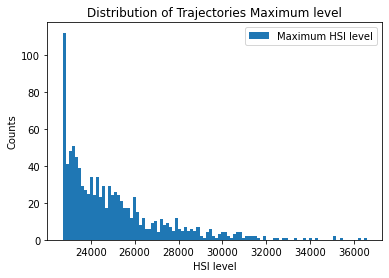

In [172]:
plt.hist(max_S, bins=100);
plt.legend(['Maximum HSI level'])
plt.title('Distribution of Trajectories Maximum level');
plt.ylabel('Counts')
plt.xlabel('HSI level')

Text(0.5, 0, 'HSI level')

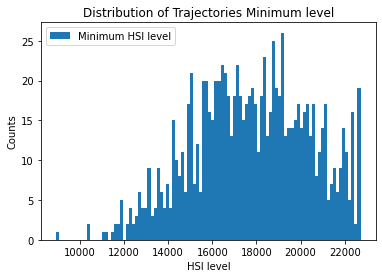

In [173]:
plt.hist(min_S, bins=100);
plt.legend(['Minimum HSI level'])
plt.title('Distribution of Trajectories Minimum level');
plt.ylabel('Counts')
plt.xlabel('HSI level')

Text(0.5, 0, 'Average daily return (%)')

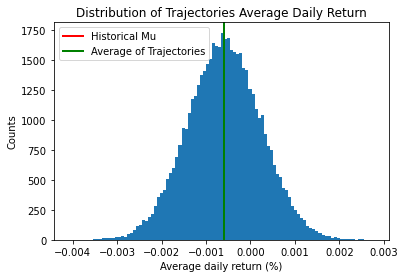

In [146]:
mean_ret = (stock_paths[:, 1:] / stock_paths[:, :-1] -1).mean(1)
plt.hist(mean_ret, bins=100);
plt.axvline(daily_log_mu, color='r',  linewidth=2);
plt.axvline(mean_ret.mean(), color='g',  linewidth=2);
plt.legend(['Historical Mu', 'Average of Trajectories'])
plt.title('Distribution of Trajectories Average Daily Return');
plt.ylabel('Counts')
plt.xlabel('Average daily return (%)')

Mean of Paths: -0.0006695101730777838, Historical mean log-ret: -0.0005855832612943568


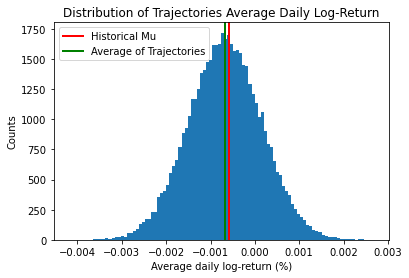

In [147]:
plt.hist(paths_log_mu, bins=100);
plt.axvline(daily_log_mu, color='r',  linewidth=2);
plt.axvline(paths_log_mu.mean(), color='g',  linewidth=2);
plt.legend(['Historical Mu', 'Average of Trajectories'])
plt.title('Distribution of Trajectories Average Daily Log-Return');
plt.ylabel('Counts')
plt.xlabel('Average daily log-return (%)')
print(f'Mean of Paths: {np.mean(paths_log_mu)}, Historical mean log-ret: {daily_log_mu}')

Text(0.5, 0, 'Daily Standard Deviation (%)')

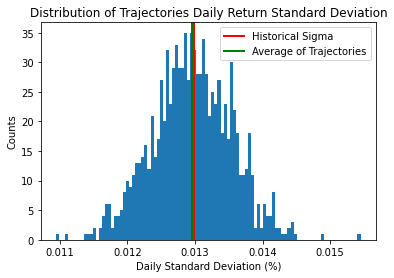

In [174]:
plt.hist(std_ret_S, bins=100);
plt.axvline(daily_log_sigma, color='r',  linewidth=2);
plt.axvline(std_ret_S.mean(), color='g',  linewidth=2);
plt.legend(['Historical Sigma', 'Average of Trajectories'])
plt.title('Distribution of Trajectories Daily Return Standard Deviation');
plt.ylabel('Counts')
plt.xlabel('Daily Standard Deviation (%)')

Text(0.5, 0, 'Daily Standard Deviation (%)')

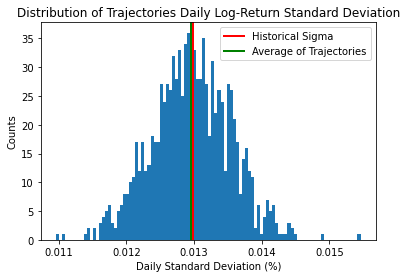

In [175]:
plt.hist(std_log_ret_S, bins=100);
plt.axvline(daily_log_sigma, color='r',  linewidth=2);
plt.axvline(std_log_ret_S.mean(), color='g',  linewidth=2);
plt.legend(['Historical Sigma', 'Average of Trajectories'])
plt.title('Distribution of Trajectories Daily Log-Return Standard Deviation');
plt.ylabel('Counts')
plt.xlabel('Daily Standard Deviation (%)')

# Section 2:  Numerical Implementations

## BSM Formula Pricing

### Gnerate all possible options

In [14]:
S0 = S0
K = [S0, 1.1 * S0, 1.2 * S0, 0.9 * S0, 0.8 * S0]
# annualized historical volatility, assuming 250 trading days
vol = daily_log_sigma * np.sqrt(250)
T  = [3/12, 6/12, 9/12, 1, 2]
r = 0.02
q = [0, 0.01]
option_type1 = ['European', 'American']
option_type2 = ['Call', 'Put']

# generate all combinations of parameters --> 200 options
all_options = list(itertools.product(*[[S0], K, [vol], [r], T, [r], q, option_type1, option_type2]))
print(len(all_options))

200


## Section III: 4 Selected Call & 4 Selected Put

In [10]:
from scipy import stats

selected_option1 = {'K': 1.1 * S0, 'T': 1, 'r': 0.02, 'q': 0, 'type1': 'Call', 'type2': 'European', 'S0': S0,  'vol': vol}
selected_option2 = {'K': 1.2 * S0, 'T': 2, 'r': 0.02, 'q': 0.0, 'type1': 'Call', 'type2': 'European', 'S0': S0, 'vol': vol}
selected_option3 = {'K': S0, 'T': 9/12, 'r': 0.02, 'q': 0.01, 'type1': 'Call', 'type2': 'European', 'S0': S0, 'vol': vol}
selected_option4 = {'K': 0.8 * S0, 'T': 3/12, 'r': 0.02, 'q': 0, 'type1': 'Call', 'type2': 'European', 'S0': S0,  'vol': vol}

selected_option5 = {'K': 1.1 * S0, 'T': 1, 'r': 0.02, 'q': 0, 'type1': 'Put', 'type2': 'European', 'S0': S0, 'vol': vol}
selected_option6 = {'K': 1.2 * S0, 'T': 2, 'r': 0.02, 'q': 0.01, 'type1': 'Put', 'type2': 'European', 'S0': S0,  'vol': vol}
selected_option7 = {'K': S0, 'T': 9/12, 'r': 0.02, 'q': 0.01, 'type1': 'Put', 'type2': 'European', 'S0': S0,'vol': vol}
selected_option8 = {'K': 0.8 * S0, 'T': 3/12, 'r': 0.02, 'q': 0, 'type1': 'Put', 'type2': 'European', 'S0': S0, 'vol': vol}

def BSM(params):
    K = params['K']
    T = params['T']
    r = params['r']
    q = params['q']
    type1 = params['type1']
    S0 = params['S0']
    vol = params['vol']
    
    d1 = 1/(vol * np.sqrt(T)) * (np.log(S0/K) + (r -q + 1/2 * vol * vol ) * T)
    d2 = d1 - vol * np.sqrt(T)
    
    if type1 == 'Call':
        return stats.norm.cdf(d1) * S0 * np.exp(-q*T) - scipy.stats.norm.cdf(d2) * K * np.exp(-r*T)
    else:
        return stats.norm.cdf(-d2) * K * np.exp(-r*T) - scipy.stats.norm.cdf(-d1) * S0 * np.exp(-q*T)
    
print(BSM(selected_option1))
print(BSM(selected_option2))
print(BSM(selected_option3))
print(BSM(selected_option4))
print(BSM(selected_option5))
print(BSM(selected_option6))
print(BSM(selected_option7))
print(BSM(selected_option8))

1169.6803784518997
1415.1950733983495
1676.980688268508
4642.770028945957
2946.259619655739
5180.389086906005
1508.5383185197788
9.540796688662226


## Section V: Monte Carlo Simulation Pricing

In [249]:
def Monte_Carlo_European(n, params):
    K = params['K']
    T = params['T']
    r = params['r']
    q = params['q']
    type1 = params['type1']
    S0 = params['S0']
    vol = params['vol']
    
    Z = np.random.normal(0,1,int(n/2))
    Z = np.append(Z,-Z)
    
    # S(T) = S0 * exp( (r-q-1/2 vol^2)T  + vol * Z * sqrt(T))
    ST = S0 * np.exp((r-q-1/2*vol*vol)*T+vol*Z*np.sqrt(T))
    if type1 == 'Call':
        payoff = np.clip(ST-K, a_min=0, a_max=None)
    else:
        payoff = np.clip(K-ST, a_min=0, a_max=None)
    
    value = np.mean(payoff) * np.exp(-r*T)
    return value

print('-----------------------------------------------------------------')
print(f'For {selected_option3["type1"]} option: K={selected_option3["K"]}, T={selected_option3["T"]}, q={selected_option3["q"]}')
print('-----------------------------------------------------------------')
for n in (100, 1000, 5000, 10000,50000, 100000, 500000,1000000, 1500000, 5000000, 10000000, 15000000, 30000000):
    bsm = BSM(selected_option3)
    mc = Monte_Carlo_European(n,selected_option3)
    dif = mc - bsm
    print(f'For n={n}, BSM: {BSM(selected_option3)}, Monte Carlo: {Monte_Carlo_European(n,selected_option3)}, difference: {dif}')

print('-----------------------------------------------------------------')
print(f'For {selected_option6["type1"]} option: K={selected_option6["K"]}, T={selected_option6["T"]}, q={selected_option6["q"]}')
print('-----------------------------------------------------------------')
for n in (100, 1000, 5000, 10000,50000, 100000, 500000,1000000, 1500000, 5000000, 10000000, 15000000, 30000000):
    bsm = BSM(selected_option6)
    mc = Monte_Carlo_European(n,selected_option6)
    dif = mc - bsm
    print(f'For n={n}, BSM: {BSM(selected_option6)}, Monte Carlo: {Monte_Carlo_European(n,selected_option6)}, difference: {dif}')

-----------------------------------------------------------------
For Call option: K=22713.01953125, T=0.75, q=0.01
-----------------------------------------------------------------
For n=100, BSM: 1676.980688268508, Monte Carlo: 1616.9456101340772, difference: -146.11409663426002
For n=1000, BSM: 1676.980688268508, Monte Carlo: 1741.7746092227605, difference: 28.81381351899131
For n=5000, BSM: 1676.980688268508, Monte Carlo: 1680.6296108671513, difference: 5.9094833465562715
For n=10000, BSM: 1676.980688268508, Monte Carlo: 1675.4467351014885, difference: 4.393199589837195
For n=50000, BSM: 1676.980688268508, Monte Carlo: 1682.08535629397, difference: 11.569065304994865
For n=100000, BSM: 1676.980688268508, Monte Carlo: 1664.2055569205556, difference: -1.9254649968104331
For n=500000, BSM: 1676.980688268508, Monte Carlo: 1672.83134914358, difference: -0.11364038858368986
For n=1000000, BSM: 1676.980688268508, Monte Carlo: 1676.2829171934427, difference: 3.0569928020640873
For n=150000

In [261]:
call_prices = list()
ns = np.linspace(start=100, stop=10000000, num=1000).astype(int)
for i in ns:
    print(i)
    call_prices.append(Monte_Carlo_European(i,selected_option3))

100
10109
20119
30129
40139
50149
60159
70169
80179
90189
100199
110209
120218
130228
140238
150248
160258
170268
180278
190288
200298
210308
220318
230327
240337
250347
260357
270367
280377
290387
300397
310407
320417
330427
340436
350446
360456
370466
380476
390486
400496
410506
420516
430526
440536
450545
460555
470565
480575
490585
500595
510605
520615
530625
540635
550645
560654
570664
580674
590684
600694
610704
620714
630724
640734
650744
660754
670763
680773
690783
700793
710803
720813
730823
740833
750843
760853
770863
780872
790882
800892
810902
820912
830922
840932
850942
860952
870962
880972
890981
900991
911001
921011
931021
941031
951041
961051
971061
981071
991081
1001090
1011100
1021110
1031120
1041130
1051140
1061150
1071160
1081170
1091180
1101190
1111200
1121209
1131219
1141229
1151239
1161249
1171259
1181269
1191279
1201289
1211299
1221309
1231318
1241328
1251338
1261348
1271358
1281368
1291378
1301388
1311398
1321408
1331418
1341427
1351437
1361447
1371457
1381467


In [278]:
put_prices = list()
ns = np.linspace(start=100, stop=10000000, num=1000).astype(int)
for i in ns:
    print(i)
    put_prices.append(Monte_Carlo_European(i,selected_option6))

100
10109
20119
30129
40139
50149
60159
70169
80179
90189
100199
110209
120218
130228
140238
150248
160258
170268
180278
190288
200298
210308
220318
230327
240337
250347
260357
270367
280377
290387
300397
310407
320417
330427
340436
350446
360456
370466
380476
390486
400496
410506
420516
430526
440536
450545
460555
470565
480575
490585
500595
510605
520615
530625
540635
550645
560654
570664
580674
590684
600694
610704
620714
630724
640734
650744
660754
670763
680773
690783
700793
710803
720813
730823
740833
750843
760853
770863
780872
790882
800892
810902
820912
830922
840932
850942
860952
870962
880972
890981
900991
911001
921011
931021
941031
951041
961051
971061
981071
991081
1001090
1011100
1021110
1031120
1041130
1051140
1061150
1071160
1081170
1091180
1101190
1111200
1121209
1131219
1141229
1151239
1161249
1171259
1181269
1191279
1201289
1211299
1221309
1231318
1241328
1251338
1261348
1271358
1281368
1291378
1301388
1311398
1321408
1331418
1341427
1351437
1361447
1371457
1381467


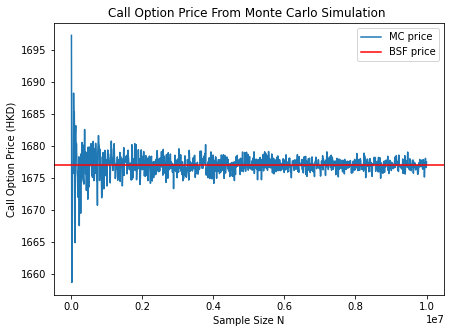

In [281]:
figure(figsize=(7, 5))
plt.ticklabel_format(useOffset=True)
plt.plot(list(ns)[1:], call_prices[1:])
plt.axhline(y=BSM(selected_option3), color='r', linestyle='-')
plt.title('Call Option Price From Monte Carlo Simulation ')
plt.ylabel('Call Option Price (HKD)')
plt.xlabel('Sample Size N')
plt.legend(['MC price', 'BSF price'])

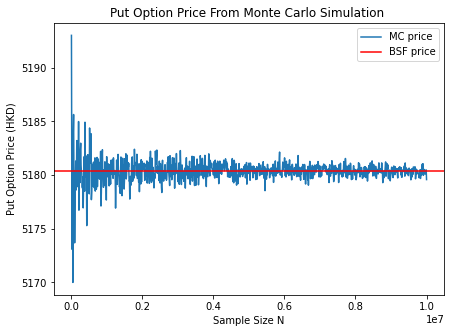

In [280]:
figure(figsize=(7, 5))
plt.ticklabel_format(useOffset=True)
plt.plot(list(ns)[1:], put_prices[1:])
plt.axhline(y=BSM(selected_option6), color='r', linestyle='-')
plt.title('Put Option Price From Monte Carlo Simulation ')
plt.ylabel('Put Option Price (HKD)')
plt.xlabel('Sample Size N')
plt.legend(['MC price', 'BSF price'])

## Section IV: Binomial Method Pricing

In [33]:
def binomial_tree_pricing(m, params):
    K = params['K']
    T = params['T']
    r = params['r']
    div_yield = params['q']
    S0 = params['S0']
    type1 = params['type1']
    type2 = params['type2']
    S0 = params['S0']
    dt = T / m
    vol = params['vol']
    u = np.exp(vol*np.sqrt(dt)) 
    d = 1/u
    enrt = np.exp(-r*dt)
    q = (np.exp((r-div_yield)*dt) - d)/(u-d)

    # Empty matrix to store stock price at [step, n_jumps]
    price_matrix = np.empty((m+1,m+1))
    price_matrix[:] = np.nan
    payoff_matrix = np.copy(price_matrix)
    price_matrix[0,0] = S0
    for step in range(m+1):
        for jumps in range(step+1):
            price_matrix[step, jumps] = S0 * (u** (2*jumps-step))
        
    for jumps in range(m+1):
        ST = price_matrix[m, jumps]
        if type1 == 'Call':
            payoff_matrix[m, jumps] = max(ST-K, 0)
        else:
            payoff_matrix[m, jumps] =  max(K-ST, 0)
    
    for step in range(m)[::-1]:
        for jumps in range(step+1):
            option_val = enrt*(q * payoff_matrix[step+1, jumps+1] + (1-q)* payoff_matrix[step+1, jumps])
            if type2 == 'American':
                if type1 == 'Call':
                    option_val = max(option_val, price_matrix[step, jumps]-K)
                else:
                    option_val = max(option_val, K-price_matrix[step, jumps])
            payoff_matrix[step, jumps] = option_val
    return payoff_matrix[0,0]

## Calculate Call & Put prices

In [35]:
binomial_call_prices = list()
binomial_put_prices = list()
m = [4, 8, 16, 32, 100, 500, 1000]
for i in m:
    call_price = binomial_tree_pricing(i,selected_option3)
    put_price = binomial_tree_pricing(i,selected_option6)
    print(f'For m={i}, call price {call_price},  put price {put_price}')
    binomial_call_prices.append(call_price)
    binomial_put_prices.append(put_price)

For m=4, call price 1581.3935500685593,  put price 5300.203030866764
For m=8, call price 1628.1007164007249,  put price 5158.017014762959
For m=16, call price 1652.3034752746032,  put price 5191.0305099396255
For m=32, call price 1664.5879225356578,  put price 5185.40803991742
For m=100, call price 1673.0038867947908,  put price 5178.966248796411
For m=500, call price 1676.1845197054133,  put price 5179.174961958339
For m=1000, call price 1676.5825540275544,  put price 5180.021742810732


## Comparison of American VS Eurpean Price

In [34]:
american_option3 = selected_option3.copy()
american_option6 = selected_option6.copy()
american_option3['type2'] = 'American'
american_option6['type2'] = 'American'
price1=binomial_tree_pricing(1000,american_option3)
price2=binomial_tree_pricing(1000,american_option6)

price1, price2

(1676.5825953878887, 5350.952048768757)

## Plot Convergence as m increase

In [292]:
binomial_call_prices_plot = list()
binomial_put_prices_plot = list()
m = np.linspace(start=5, stop=2000, num=100).astype(int)
for i in m:
    print(i)
    call_price = binomial_tree_pricing(i,selected_option3)
    put_price = binomial_tree_pricing(i,selected_option6)
    binomial_call_prices_plot.append(call_price)
    binomial_put_prices_plot.append(put_price)

5
25
45
65
85
105
125
146
166
186
206
226
246
266
287
307
327
347
367
387
408
428
448
468
488
508
528
549
569
589
609
629
649
670
690
710
730
750
770
790
811
831
851
871
891
911
931
952
972
992
1012
1032
1052
1073
1093
1113
1133
1153
1173
1193
1214
1234
1254
1274
1294
1314
1335
1355
1375
1395
1415
1435
1455
1476
1496
1516
1536
1556
1576
1596
1617
1637
1657
1677
1697
1717
1738
1758
1778
1798
1818
1838
1858
1879
1899
1919
1939
1959
1979
2000


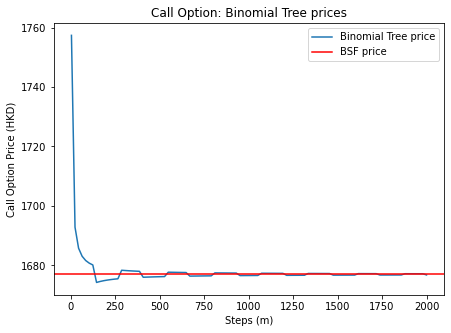

In [293]:
figure(figsize=(7, 5))
plt.ticklabel_format(useOffset=True)
plt.plot(m, binomial_call_prices_plot)
plt.axhline(y=BSM(selected_option3), color='r', linestyle='-')
plt.title('Call Option: Binomial Tree prices')
plt.ylabel('Call Option Price (HKD)')
plt.xlabel('Steps (m)')
plt.legend(['Binomial Tree price', 'BSF price'])

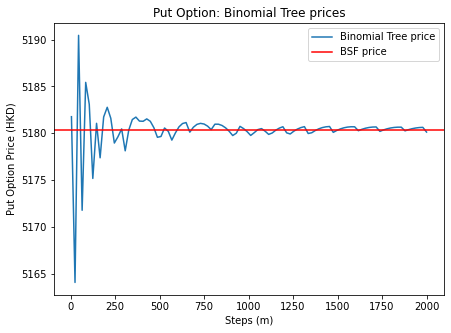

In [294]:
figure(figsize=(7, 5))
plt.ticklabel_format(useOffset=True)
plt.plot(m, binomial_put_prices_plot)
plt.axhline(y=BSM(selected_option6), color='r', linestyle='-')
plt.title('Put Option: Binomial Tree prices')
plt.ylabel('Put Option Price (HKD)')
plt.xlabel('Steps (m)')
plt.legend(['Binomial Tree price', 'BSF price'])

# Section V: Finite Difference Method

## Illustration of non-uniform grid

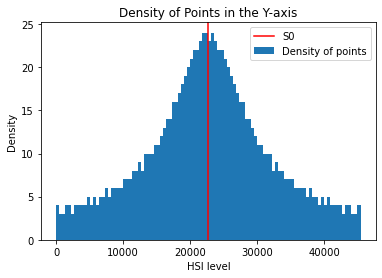

In [31]:
normal_sd = np.linspace(start=-2, stop=2, num=1000)
normal_density = scipy.stats.norm.pdf(normal_sd)
inverse_density = 1 / normal_density
dS = inverse_density / np.sum(inverse_density) * (2 - 0)
S_grids = np.zeros(1000+1)
S_grids[1:] = dS
S_grids = np.cumsum(S_grids) 
S_grids = S_grids* S0
plt.hist(S_grids, bins=100);
plt.title('Density of Points in the Y-axis')
plt.xlabel('HSI level')
plt.ylabel('Density')
plt.axvline(x=S0, color='r');
plt.legend([ 'S0', 'Density of points'])

## Implementation of non-uniform Crank-Nicolson Method

In [64]:
def LVF_vol(alpha, St, beta, value_for_S_is_zero):
    ret = np.zeros(St.shape[0])
    ret[1:] = alpha * np.power(St[1:], 1-beta)
    ret[0] = value_for_S_is_zero
    return ret

def cal_matrics(dt, r, q, vol_vector, S_grids):
    # for j=1,...,M 
    dS = np.diff(S_grids)
    # for j=0,1,...,M 
    vol_sqrt = np.power(vol_vector,2)
    # for j=0,1,...,M 
    S_j = S_grids
    # for j=0,1,...,M 
    S_sqrt = np.power(S_j,2)
    # for j=1,...,M 
    dS_sqrt = np.power(dS, 2)
    
    # for j=1,1,...,M-1
    sum_dS = dS[:-1] + dS[1:]
    sqrt_term = (dt * vol_sqrt[1:-1] * S_sqrt[1:-1])/(2*(dS_sqrt[:-1]*dS[1:]+dS_sqrt[1:]*dS[:-1]))
    rq_term = dt*(r-q)*S_j[1:-1]/(2*sum_dS)
    
    b =  -(sqrt_term *sum_dS )-r/2*dt
    c = rq_term + (sqrt_term * dS[:-1]) 
    a = (sqrt_term*dS[1:])  - rq_term 
    
    B = diags([1 - b, -a[1:], -c[:-1]], [0, -1, 1]).toarray()
    C = diags([1 + b, a[1:], c[:-1]], [0, -1, 1]).toarray()
     
    return a,b,c,B,C

def crank_nicholson_method_european(vol_func, t_steps, S_steps, params, max_moneyness=2, min_moneyness=0, alpha=20, beta=2, ret_price=True,
                                   value_for_S_is_zero=100):
    # round steps to nearest hundreds
    #t_steps = max(t_steps - t_steps%100,100)
    #S_steps = max(S_steps - S_steps%100,100)
    
    S0 = params['S0']
    T = params['T']
    K = params['K']
    r = params['r']
    q = params['q']
    type1 = params['type1']
    r_adj = r-q
    
    dt = T/t_steps
    t_pts = np.arange(0,T+dt,dt)
    
    # nonuniform grids
    normal_sd = np.linspace(start=-2, stop=2, num=S_steps)
    normal_density = scipy.stats.norm.pdf(normal_sd)
    inverse_density = 1 / normal_density
    dS = inverse_density / np.sum(inverse_density) * (max_moneyness - min_moneyness)
    S_grids = np.zeros(S_steps+1)
    S_grids[1:] = dS
    S_grids = np.cumsum(S_grids) 
    S_grids = np.sort(S_grids)
    S_grids = S_grids* S0
    
    f = np.empty((len(t_pts),len(S_grids)))
    f[:] = np.nan
    
    # boundary conditions
    if type1 == 'Call':
        # expiry boundary conditions
        f[-1, :] = np.clip(S_grids-K, a_min=0, a_max=None)
        # upper boundary for S_max, discounted
        f[:, -1] = np.clip(S_grids[-1]-K, a_min=0, a_max=None) * np.exp(-r*(T-t_pts))
        # lower boundary for S_0
        f[:, 0] = 0
        
    else:
        # expiry boundary conditions
        f[-1, :] = np.clip(K-S_grids, a_min=0, a_max=None)
        # upper boundary for S_max
        f[:, -1] = 0
        # lower boundary for S_0, discounted
        f[:, 0] = np.clip(K-S_grids[0], a_min=0, a_max=None)* np.exp(-r*(T-t_pts))
    
    vol_vector = LVF_vol(alpha, S_grids, beta, value_for_S_is_zero)
    
    # calculate matrics
    a,b,c,B,C = cal_matrics(dt, r, q, vol_vector, S_grids)
    B_inv = np.linalg.inv(B)
    for i in range(len(t_pts)-1)[::-1]:
        f_i = f[i+1, :]
        f_im1 = f[i, :]
    
        d = np.zeros(f_i.shape[0])[1:-1]
        d[0] = a[0] * (f_i[0] + f_im1[0])
        d[-1] = c[-1] * (f_i[-1] + f_im1[-1])
        
        next_F = np.dot(B_inv,(np.dot(C, f_i[1:-1]) + d))
        f[i, :][1:-1] = next_F   
        
    if ret_price:
        result= pd.DataFrame({'S0': S_grids[0:].flatten(), 'val': f[0,:].flatten()})
        return result.iloc[(result['S0']-S0).abs().argsort()[0]][1]
    else:
        return f, t_pts, S_grids


### Define two options to price using Crank-Nicolson Method

In [5]:
CEV_options1 = {'T': 1, 'K': 0.8*100, 'r':0.02, 'q':0.01, 'S0': 100, 'type1':'Call'}
CEV_options2 = {'T': 1, 'K': 0.8*100, 'r':0.02, 'q':0.01, 'S0': 100, 'type1':'Put'}

## Convergence in price for call option under CEV

In [393]:
t_steps = np.linspace(start=1, stop=1000, num=1000)
t_prices = np.zeros(t_steps.shape[0])
for i in range(t_steps.shape[0]):
    print(i)
    t_step = t_steps[i]
    t_prices[i] = crank_nicholson_method_european(0,t_step,500,CEV_options1,alpha=20,beta=2, ret_price=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

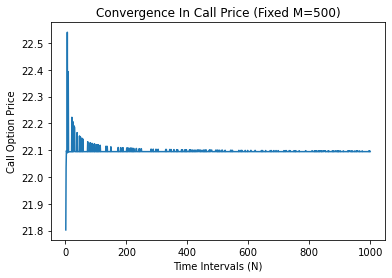

In [394]:
fig, ax = plt.subplots()
ax.set_title('Convergence In Call Price (Fixed M=500)')
ax.ticklabel_format(useOffset=False)
ax.plot(t_steps, t_prices)
ax.set_xlabel('Time Intervals (N)')
ax.set_ylabel('Call Option Price')
plt.show()

In [24]:
s_steps = np.linspace(start=10, stop=1000, num=1000).astype(int)
s_prices = np.zeros(s_steps.shape[0])
for i in range(s_steps.shape[0]):
    print(i)
    s_step = s_steps[i]
    s_prices[i] = crank_nicholson_method_european(0,500,s_step,CEV_options1 , ret_price=True)
    #a = crank_nicholson_method_european(0,100,s_step,CEV_options1,alpha=20,beta=2, ret_price=True)
    #print(a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

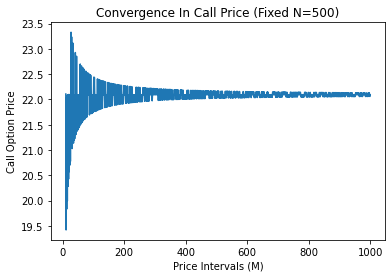

In [27]:
fig, ax = plt.subplots()
ax.set_title('Convergence In Call Price (Fixed N=500)')
ax.ticklabel_format(useOffset=False)
ax.plot(s_steps, s_prices)
ax.set_xlabel('Price Intervals (M)')
ax.set_ylabel('Call Option Price')
plt.show()

## Convergence in price for put option under CEV

In [26]:
t_steps = np.linspace(start=1, stop=1000, num=1000)
t_prices = np.zeros(t_steps.shape[0])
for i in range(t_steps.shape[0]):
    print(i)
    t_step = t_steps[i]
    t_prices[i] = crank_nicholson_method_european(0,t_step,500,CEV_options2,alpha=20,beta=2, ret_price=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

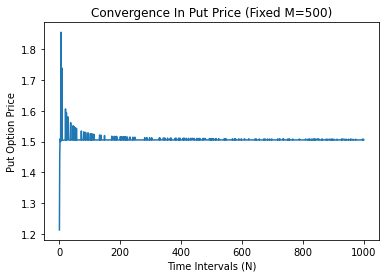

In [29]:
fig, ax = plt.subplots()
ax.set_title('Convergence In Put Price (Fixed M=500)')
ax.ticklabel_format(useOffset=False)
ax.plot(t_steps, t_prices)
ax.set_xlabel('Time Intervals (N)')
ax.set_ylabel('Put Option Price')
plt.show()

In [28]:
s_steps = np.linspace(start=10, stop=1000, num=1000).astype(int)
s_prices = np.zeros(s_steps.shape[0])
for i in range(s_steps.shape[0]):
    print(i)
    s_step = s_steps[i]
    s_prices[i] = crank_nicholson_method_european(0,500,s_step,CEV_options2 , ret_price=True)
    #a = crank_nicholson_method_european(0,100,s_step,CEV_options1,alpha=20,beta=2, ret_price=True)
    #print(a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

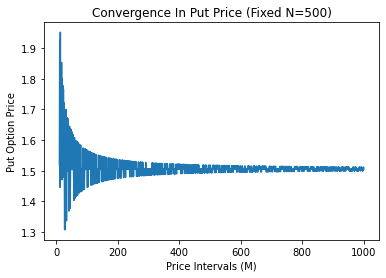

In [30]:
fig, ax = plt.subplots()
ax.set_title('Convergence In Put Price (Fixed N=500)')
ax.ticklabel_format(useOffset=False)
ax.plot(s_steps, s_prices)
ax.set_xlabel('Price Intervals (M)')
ax.set_ylabel('Put Option Price')
plt.show()

# Matrix of option prices under CEV

In [61]:
CEV_options2 = {'T': 1, 'K': 100, 'r':0.02, 'q':0.01, 'S0': 100, 'type1':'Put'}
f, t_pts, S_pts = crank_nicholson_method_european(0,500,1000,CEV_options1,alpha=0.2, beta=1, ret_price=False)


In [62]:
S_pts[-1]

199.9999999999999

In [63]:
f[:, -1]

array([ 98.01986733,  98.0237882 ,  98.02770923,  98.03163042,
        98.03555176,  98.03947326,  98.04339492,  98.04731674,
        98.05123871,  98.05516084,  98.05908312,  98.06300556,
        98.06692816,  98.07085092,  98.07477383,  98.0786969 ,
        98.08262012,  98.08654351,  98.09046705,  98.09439075,
        98.0983146 ,  98.10223861,  98.10616278,  98.1100871 ,
        98.11401159,  98.11793622,  98.12186102,  98.12578597,
        98.12971108,  98.13363635,  98.13756177,  98.14148735,
        98.14541309,  98.14933899,  98.15326504,  98.15719125,
        98.16111762,  98.16504414,  98.16897082,  98.17289766,
        98.17682465,  98.1807518 ,  98.18467911,  98.18860658,
        98.1925342 ,  98.19646198,  98.20038992,  98.20431801,
        98.20824626,  98.21217467,  98.21610324,  98.22003196,
        98.22396084,  98.22788988,  98.23181907,  98.23574842,
        98.23967793,  98.2436076 ,  98.24753742,  98.2514674 ,
        98.25539754,  98.25932783,  98.26325828,  98.26

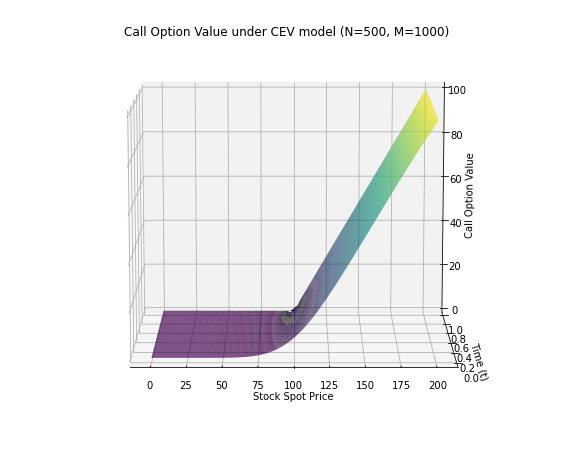

In [45]:
f, t_pts, S_pts = crank_nicholson_method_european(0,500,1000,CEV_options1, ret_price=False)
X, Y = np.meshgrid(S_pts, t_pts)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
# ax.plot_wireframe(X, Y, f, color='black')
ax.set_xlabel('Stock Spot Price')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Call Option Value');
ax.set_title('Call Option Value under CEV model (N=500, M=1000)')
# ax.view_init(view_angle[0], view_angle[1])
ax.view_init(10, 270)

fig.set_size_inches(10, 8)

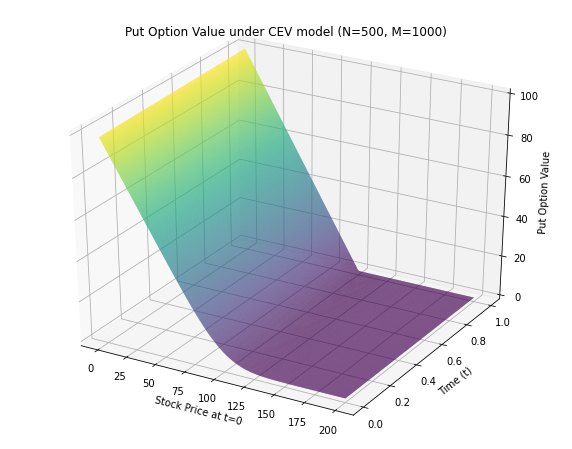

In [41]:
f, t_pts, S_pts = crank_nicholson_method_european(0,500,1000,CEV_options1, ret_price=False)
X, Y = np.meshgrid(S_pts, t_pts)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
# ax.plot_wireframe(X, Y, f, color='black')
ax.set_xlabel('Stock Spot Price')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Call Option Value');
ax.set_title('Call Option Value under CEV model (N=500, M=1000)')
# ax.view_init(view_angle[0], view_angle[1])
ax.view_init(20, 250)

fig.set_size_inches(10, 8)

# Check convergence under BSM model

In [67]:
s_steps = np.linspace(start=100, stop=3000, num=500).astype(int)
s_prices_bsm = np.zeros(s_steps.shape[0])
for i in range(s_steps.shape[0]):
    s_step = s_steps[i]
    s_prices_bsm[i] = crank_nicholson_method_european(0,100,s_step,selected_option3,alpha = selected_option6['vol'], beta=1, ret_price=True)

NameError: name 'bsm' is not defined

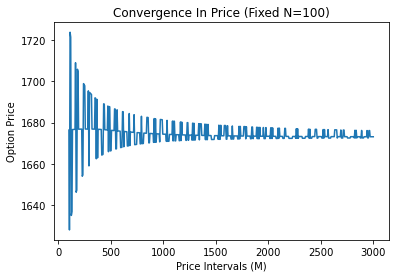

In [68]:
fig, ax = plt.subplots()
ax.set_title('Convergence In Price (Fixed N=100)')
ax.ticklabel_format(useOffset=False)
ax.plot(s_steps, s_prices_bsm)
ax.set_xlabel('Price Intervals (M)')
ax.set_ylabel('Option Price')
ax.axhline(y=bsm, color='r', linestyle='-')
ax.legend([ 'Crank-Nocolson Method', 'BSM price'])
plt.show()

## Tabulate put option value

In [75]:
CEV_options = {'T': 1, 'K':1, 'r':0.02, 'q':0.01, 'S0': 100, 'type1':'Put'}
for k in np.arange(0.9, 1.1, 0.02):
    CEV_options['K'] = CEV_options['S0'] * k
    print(f'For K={k}*S0, Put option value is {crank_nicholson_method_european(0,200,1000,CEV_options, ret_price=True)}')

For K=0.9*S0, Put option value is 3.6160653928643027
For K=0.92*S0, Put option value is 4.222616608606579
For K=0.9400000000000001*S0, Put option value is 4.899500780747987
For K=0.9600000000000001*S0, Put option value is 5.649570435236178
For K=0.9800000000000001*S0, Put option value is 6.475035174786576
For K=1.0*S0, Put option value is 7.374967608325255
For K=1.02*S0, Put option value is 8.357385697790017
For K=1.04*S0, Put option value is 9.415038917049646
For K=1.06*S0, Put option value is 10.54960002066336
For K=1.08*S0, Put option value is 11.759560516458462
For K=1.1*S0, Put option value is 13.042704948817256


## Arbitrarily large value for Sigma(0)

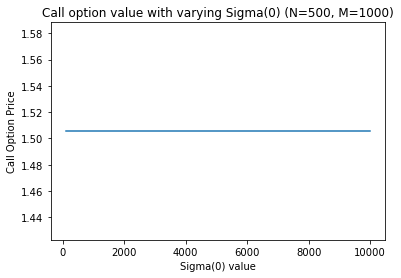

In [72]:
sigma_prices = list()
for sigma_val in [100,1000,5000,10000]:
    sigma_prices.append(crank_nicholson_method_european(0,500,1000,CEV_options2 , ret_price=True, value_for_S_is_zero=sigma_val))
fig, ax = plt.subplots()
ax.set_title('Call option value with varying Sigma(0) (N=500, M=1000)')
ax.ticklabel_format(useOffset=False)
ax.plot([100,1000,5000,10000], sigma_prices)
ax.set_xlabel('Sigma(0) value')
ax.set_ylabel('Call Option Price')
plt.show()

## Implied Volatility Under CEV

In [150]:
import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_put(S, K, T, r, q, vol):
    d1 = (np.log(S/K) + (r -q+ 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return  np.exp(-r * T) * K * norm.cdf(-d2) -S * norm.cdf(-d1)*np.exp(-q*T)

def bs_vega(S, K, T, r,q, sigma):
    d1 = (np.log(S / K) + (r -q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)*np.exp(-q*T)

def find_vol(target_value, S, K, T, r,q, *args):
    MAX_ITERATIONS = 100000
    PRECISION = 1.0e-6
    sigma = 0.2
    for i in range(0, MAX_ITERATIONS):
        price = bs_put(S, K, T, r,q, sigma)
        vega = bs_vega(S, K, T, r,q, sigma)
        diff = target_value - price  
        vega = bs_vega(S, K, T, r, q, sigma)
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega
    return sigma 

In [ ]:
CEV_options = {'T': 3/12, 'K':None, 'r':0.02, 'q':0.01, 'S0': 100, 'type1':'Put'}
all_strikes = [0.8, 0.9, 1.1, 1.2]
implied_vol_3_mo = list()
implied_vol_6_mo = list()

for k in all_strikes:
    CEV_options['T'] = 3/12
    CEV_options['K'] = k * CEV_options['S0']
    price1 = crank_nicholson_method_european(0,1000,2000,CEV_options , ret_price=True)
    #print(price1)
    implied_vol = find_vol(target_value=price1,
                           S=CEV_options['S0'],
                           K=CEV_options['K'],
                           T=CEV_options['T'],
                           r=CEV_options['r'],
                           q=CEV_options['q'])
    print(implied_vol)
    implied_vol_3_mo.append(implied_vol)
    
    CEV_options['T'] = 6/12
    price2 = crank_nicholson_method_european(0,1000,2000,CEV_options , ret_price=True)
    #print(price2)
    implied_vol = find_vol(target_value=price2,
                           S=CEV_options['S0'],
                           K=CEV_options['K'],
                           T=CEV_options['T'],
                           r=CEV_options['r'],
                           q=CEV_options['q'])
    print(implied_vol)
    implied_vol_6_mo.append(implied_vol)    

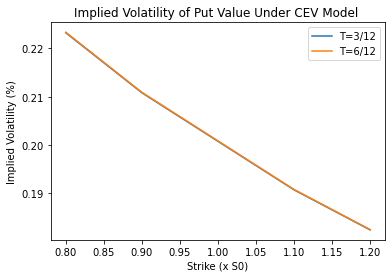

In [159]:
plt.plot(all_strikes, implied_vol_3_mo)
plt.plot(all_strikes, implied_vol_6_mo)
plt.title('Implied Volatility of Put Value Under CEV Model ')
plt.xlabel('Strike (x S0)')
plt.ylabel('Implied Volatility (%)')
plt.legend(['T=3/12', 'T=6/12'])